In [391]:
import lmfit
from lmfit.models import LorentzianModel
import numpy as np
from matplotlib import pyplot as plt
import rampy as rp
import scipy
import spectrochempy

In [388]:
def raman(name,min,max):
    spectrum = np.genfromtxt(name)
    x_new = np.arange(min, max, 0.5)
    y_new = rp.resample(spectrum[:,0], spectrum[:,1], x_new)
    spectrum_resample = np.vstack((x_new,y_new)).T
    y_smo_10 = rp.smooth(spectrum_resample[:,0],spectrum_resample[:,1],method="whittaker",Lambda=3000,window_length=7)
    spectrum_resample = np.vstack((x_new,y_smo_10)).T
    d = scipy.signal.argrelextrema(spectrum_resample, np.less)
    points = len(d[0])
    bir=np.zeros((points,2))
    for i in range(len(d[0])):
        wavenumber=spectrum_resample[d[0][i]][0]
        bir[i][0]=wavenumber
        bir[i][1]=wavenumber+5
    y_corr, y_base = rp.baseline(spectrum_resample[:,0],spectrum_resample[:,1],bir,'drPLS')
    x = spectrum_resample[:,0]
    x_fit = x[np.where((x > min)&(x < max))]
    y_fit = y_corr[np.where((x > min)&(x < max))]
    spectrum_corr = np.column_stack((x_fit,y_fit))
    ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
    y_fit[:,0] = y_fit[:,0]/np.amax(y_fit[:,0])*10 # normalise spectra to maximum intensity, easier to handle
    spectrum_fit = np.column_stack((x_fit,y_fit))
    sigma = abs(ese0*y_fit[:,0]) #calculate good ese
    return spectrum_resample,spectrum_corr,spectrum_fit,y_base,ese0,sigma

In [389]:
spectrum_resample,spectrum_corr,spectrum_fit,y_base,ese0,sigma =raman('2.dat',840,1300)

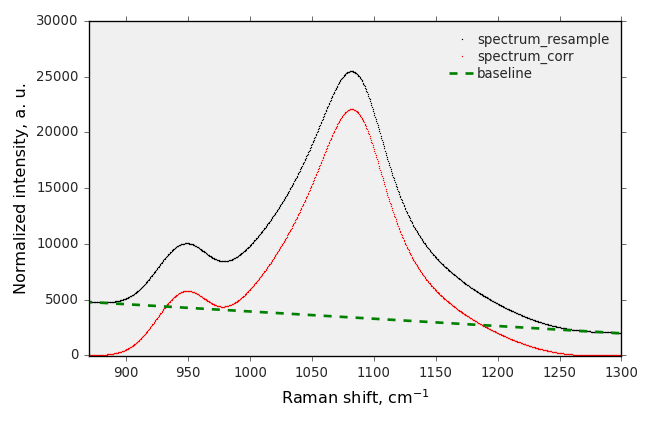

In [390]:
plt.figure()
plt.plot(spectrum_resample[:,0],spectrum_resample[:,1],'ko',markersize=1,label='spectrum_resample')
plt.plot(spectrum_corr[:,0],spectrum_corr[:,1],'ro',markersize=1,label='spectrum_corr')
plt.plot(spectrum_resample[:,0],y_base,'g--',label='baseline',linewidth=2)
plt.ylim(-20,30000)
plt.xlim(870,1300)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
plt.ylabel("Normalized intensity, a. u.", fontsize = 12)
plt.legend(fontsize=10)

In [344]:
def residual(pars,x,data=None,eps=None):
    model=0.0
    peaks = []
    for i in range(5):
        a = 'a'+ str(i+1)
        f = 'f'+ str(i+1)
        l = 'l'+ str(i+1)
        peak = 'peak'+str(i+1)
        aa = pars[a].value
        ff = pars[f].value
        ll = pars[l].value
        locals()[peak] = rp.gaussian(x,aa,ff,ll)
        model += locals()[peak]
        peaks.append(locals()[peak])
    if data is None:
        return model, peaks # if we don't have data, the function only returns the direct calculation
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

In [303]:
def peak_finder(data):
    peaks_1 = scipy.signal.find_peaks(data.T[1])
    saddles = scipy.signal.argrelmin(data.T[1])
    peaks = np.insert(peaks_1[0],0,saddle[0])
    wavenumbers = []
    for peak in peaks:
        wavenumbers.append(data.T[0][peak])
    wavenumbers = np.sort(wavenumbers)
    return wavenumbers



In [380]:
wavenumbers = peak_finder(spectrum_fit)
def param_gen(n,wavenumbers):
    params = lmfit.Parameters()
    for i in range(n):
        a = 'a'+ str(i+1)
        f = 'f'+ str(i+1)
        l = 'l'+ str(i+1)
        wavenumber = wavenumbers[i]
        params.add_many((a, 3, True , 0 , None, None),
                        (f,wavenumber+20,True,wavenumber-20,wavenumber+40,None),
                        (l, 30 , True , 0 , None, None))
    return params
params= param_gen(5,wavenumbers)

In [386]:
wavenumbers

array([     871,    949.5,      978,     1082,     1278])

In [ ]:
plt.figure()
plt.plot(spectrum_fit[:,0],spectrum_fit[:,1],'k*',markersize=2)
plt.plot(spectrum_fit[:,0],yout,'ro',markersize=1)
for i in range(len(peaks)):
    plt.plot(spectrum_fit[:,0],peaks[i],'g-',linewidth=1.1)
plt.xlim(870,1300)
plt.ylim(0,11)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)

In [381]:
params['f1'].vary = False
params['f2'].vary = False
params['f3'].vary = False
params['f4'].vary = False
params['f5'].vary = False

In [382]:
algo = 'powell'
result = lmfit.minimize(residual, params, method = algo, args=(spectrum_fit[:,0], spectrum_fit[:,1]))

In [383]:
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
params['f4'].vary = True
params['f5'].vary = True
result2 = lmfit.minimize(residual, params, method = algo, args=(spectrum_fit[:,0], spectrum_fit[:,1]))

In [384]:
model = lmfit.fit_report(result2.params)
yout, peaks= residual(result2.params,spectrum_fit[:,0])

Text(0, 0.5, 'Normalized intensity, a. u.')

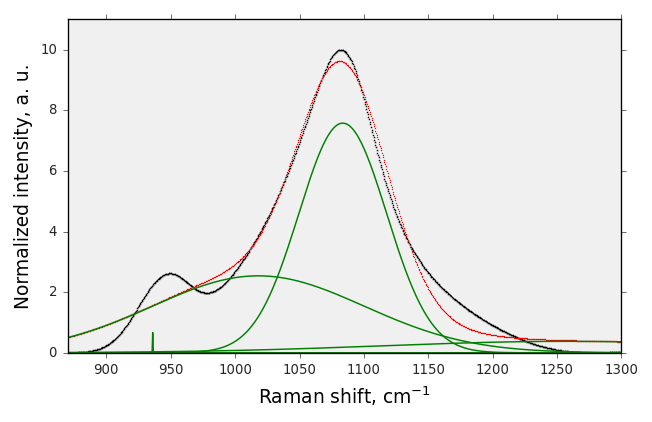

In [385]:
plt.figure()
plt.plot(spectrum_fit[:,0],spectrum_fit[:,1],'k*',markersize=2)
plt.plot(spectrum_fit[:,0],yout,'ro',markersize=1)
for i in range(len(peaks)):
    plt.plot(spectrum_fit[:,0],peaks[i],'g-',linewidth=1.1)
plt.xlim(870,1300)
plt.ylim(0,11)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)